# __[:+:]__ Heart Machine __[:+:]__

In [3]:
# import os
import numpy as np
import matplotlib.pyplot as plt
# from cardiac_ml_tools import read_data_dirs
# from cardiac_ml_tools import get_activation_time
# from cardiac_ml_tools import get_standard_leads
import tensorflow as tf
from tensorflow import keras, initializers
# import keras
from keras import Model
# from keras import layers
from keras.models import load_model
# from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input, Conv2D, Conv1D, Concatenate, \
     MaxPool1D, Dropout, PReLU,BatchNormalization, Flatten,UpSampling2D, LeakyReLU, Dense, Input, add, Multiply
# from keras.layers import MaxPool2D, GlobalAvgPool2D, Activation
from keras.losses import MeanSquaredError
# from keras.applications import VGG19
import itertools
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
# import glob
# import time
# import pandas as pd
# import PIL
# from numba import jit, cuda
# import stumpy as sp
# from numpy.random import randint
# from keras.layers.convolutional import MaxPooling1D
local_path= r"\\wsl.localhost\\Ubuntu-18.04\\home\\koogleblitz\\Cardiac-Electrocardiography\\notebooks\\"
default_path= ''
colab_path= r'/content/drive/MyDrive/dsc_dataset/'
git_path= r'/workspaces/codespaces-jupyter/'


## __[+]__ 'Config' -----------------------------------------------------------|
outPath= default_path

#[+]------------------------------------------------------------------------------------------------\\
currentModel= 'ecg2vm_v2_e100'
generateNewModel= False
loadCurrentModel= True
trainCurrentModel= True
num_epochs = 5
saveInterval= 5

loadFullData= True
loadPartialData= False
splitData=True

predict= True
mdlLbl= "ADHD Prediction"
mapLbl= "Prediction"
epochs= '100'
#[+]-----------------------------------------------------------------------------------------------//

# [DATA]
datapaths_train = r'./intracardiac_dataset/data_hearts_dd_0p2'
datapaths_val = r'./intracardiac_dataset/data_hearts_dd_0p2'
# data_scaling_ecg = normalized_unit
# data_scaling_vm = normalization
num_timesteps = 500
all_channels = True
input_dim = 12
output_dim = 75

# [MODEL]
hidden_dim = 100
layer_dim = 2

# [TRAIN]
learning_rate = 1e-3
gamma_scheduler = 1.0
step_size_scheduler = 100
batch_size = 32
# num_epochs = 10
grad_clippling = False
dropout = 0.0
loss_norm = 'MSE' #keras.losses import MeanSquaredError
load_model = False
# model_path = r'./intracardiac_dataset/data_hearts_dd_0p2'

# [SAVE]
# outputstats_file = trainingStats
checkpoint_rate = 200
# out_name = mymodel
progressbar = False


# device_name = tf.test.gpu_device_name()
# print('Device: ', device_name)
# if device_name != '':
#     device_name = "GPU"
# else:
#     device_name = "CPU"
# print('\nThe device is {}\n'.format(device_name))


# TensorFlow automatically uses the appropriate device
# model = SqueezeNet(version='1_1', dropout=dropout, kernel_size=knl)  
# model = model.to(device)

# Squeezenet/Mikelnet: 
    #loss function: 'squared error'  :keras.losses import MeanSquaredError
    #test-train split: random 95/5
    #optimizer: adam
    #Learning rat: 0.001

66.66666666666667


## __[+]__ Load Data and Model

In [5]:
## (batchCount, batch_size, signalCount, timeSteps)
## -----------------------------------------------------------------------------|
if(loadCurrentModel):
    mdl= keras.models.load_model(outPath+ currentModel+'.h5', compile=True)
    print('\n[+]- Loaded Model: ', currentModel)
else: print('\n[x]- No Model Loaded --')

#ECG_Data_NORM.npy and vmData_NORM.npy are normalized by Brandon and is somehow smaller despite having the same-sized matrices
if(loadFullData):
    print('\n[+]- Loading Full Data...')
    ecgNorm= np.load(outPath+ 'ECG_Data_NORM.npy')
    print('ecgNorm: ', ecgNorm.shape)
    vmNorm= np.load(outPath+ 'VmData_NORM.npy')
    print('\nVmData_NORM: ', vmNorm.shape)

if(loadPartialData):
    print('\n[+]- Loading Partial Data...')
    vmNorm= np.load(outPath+ 'vm_norm_T_70.npy')
    print('\nVmData_NORM: ', vmNorm.shape)
    ecgNorm= np.load(outPath+ 'ecgNorm_70.npy')
    print('ecgNorm: ', ecgNorm.shape)

if (splitData):
    print('\n[+]- Splitting Data...')
    ecg_train, ecg_test, volt_train, volt_test= train_test_split(ecgNorm, vmNorm, test_size= 0.05, random_state=42)
    print('ecg_train, ecg_test, vm_train, vm_test: \n', ecg_train.shape, ecg_test.shape,'|', volt_train.shape, volt_test.shape)
    # testEcg_tmp= np.load('testEcg_tmp.npy')
    # testVm_tmp= np.load('testVm_tmp.npy')


[+]- Loaded Model:  transVolt_v2_e100

[+]- Loading Full Data...
ecgNorm:  (16117, 500, 12)

VmData_NORM:  (16117, 500, 75)

[+]- Splitting Data...
ecg_train, ecg_test, vm_train, vm_test: 
 (15311, 500, 12) (806, 500, 12) | (15311, 500, 75) (806, 500, 75)


## __[+]__ -- Model Components

In [3]:
#[+]-----------MikelNet----------------------------------------------------------------------------\\
# torch.nn.Conv1d(n_channels =12, out_channels =96, kernel_size=7, stride=2)
#[+:] sqExpand: the output shape of the squeeze layer is the input shape of the expand layers
def fire_1D_fx(x,  initShape,sqExpand,exFilter_1x1, exFilter_3x3):
    squeezed     =  Conv1D(input_shape= (None, initShape), filters= sqExpand, kernel_size=1, activation='relu')(x)
    expanded_1x1 =  Conv1D(input_shape= (None,sqExpand), filters=exFilter_1x1,  kernel_size=1, activation='relu')(squeezed)
    expanded_3x3 =  Conv1D(input_shape= (None,sqExpand), filters= exFilter_3x3, kernel_size=3, activation='relu', padding='same')(squeezed)
    x= Concatenate()([expanded_1x1, expanded_3x3])
    print('        [fire_1D_fx:]:==> x', x.shape)
    # x= Activation('relu')(x)
    return x  


def ecg2vm_fx(x, dropout= 0.5, kernel_size = 3):
    print('\n[:+:] --------------------------------------------------------------------------- [:+:]\n')
    # Conv1D(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    #[+]-- Conv1D layers expect their input to have a rank of 3, with dimensions (batch_size, steps, input_dim). so not sure if (12,500) is correct
    # x = Reshape((12, 500))(x)
    print('x--> [ecg2vm_fx]: ', x.shape)
    x = Reshape((500,12))(x)
    print('x--> [ecg2vm_fx.Conv1D] reshaped: ', x.shape)
    x= Conv1D(input_shape= (None,12), filters=64, kernel_size=kernel_size, strides=1, padding='same')(x)
    print('    \nx--> [MaxPool1D_1] : ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,64, 16, 64, 64)
    x= fire_1D_fx(x,128, 16, 64, 64)
    print('    \nx--> [MaxPool1D_2]: ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,128, 32, 128, 128)
    x= fire_1D_fx(x,256, 32, 128, 128)
    print('    \nx--> [MaxPool1D_3]: ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,256, 48, 192, 192)
    x= fire_1D_fx(x,384, 48, 192, 192)
    x= fire_1D_fx(x,384, 64, 256, 256)
    x= fire_1D_fx(x,512, 64, 256, 256)
    print('\n    [ecg2vm_fx:]:==> x', x.shape)
    return x


def transVolt_fx(x, dropout= 0.5, kernel_size = 3, div= 1):
    print('\n[:+:] --------------  x--> [transVolt_fx]: ', x.shape,'----------------------------------------------------------- [:+:]\n')
    # Conv1D(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    #[+]-- Conv1D layers expect their input to have a rank of 3, with dimensions (batch_size, steps, input_dim). so not sure if (12,500) is correct
    # x = Reshape((12, 500))(x)

    x = Reshape((500//div,12))(x)
    print('x--> [ecg2vm_fx.Conv1D] reshaped: ', x.shape)

    x= Conv1D(input_shape= (None,12//div), filters=64//div, kernel_size=kernel_size, strides=1, padding='same')(x)
    print('    \nx--> [MaxPool1D_1] : ', x.shape)

    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,64//div, 16//div, 64//div, 64//div)
    x= fire_1D_fx(x,128//div, 16//div, 64//div, 64//div)
    print('    \nx--> [MaxPool1D_2]: ', x.shape)

    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,128//div, 32//div, 128//div, 128//div)
    x= fire_1D_fx(x,256//div, 32//div, 128//div, 128//div)
    print('    \nx--> [MaxPool1D_3]: ', x.shape)

    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,256//div, 48//div, 192//div, 192//div)
    x= fire_1D_fx(x,384//div, 48//div, 192//div, 192//div)
    x= fire_1D_fx(x,384//div, 64//div, 256//div, 256//div)
    x= fire_1D_fx(x,512//div, 64//div, 256//div, 256//div)
    print('\n    [ecg2vm_fx:]:==> x', x.shape)
    return x


def homeStretch_fx(x, dropout= 0.5):
    print('\nx --> [homeStretch_fx]: ', x.shape)
    Dropout(rate=dropout)
    x=Conv1D(input_shape=(None, 512), filters=75, kernel_size=1, padding='valid' )(x)
    return x


def attentionMatrix_fx(inputs, r=1):
    print('\n[:+:]-------------------- x-->[attentionMatrix_fx] (bat, h, w, ch)=', inputs.shape)
    # bat, h, w, ch= inputs.shape
    ch= inputs.shape[3]

    #[+]-- Squeeze each channel matrix into a single 1x1 value
    x= GlobalAveragePooling2D()(inputs)
    print('    [GlobalAveragePooling2D](squeezed) x -->: ', x.shape)

    #[+]-- The bottleneck MLP is used to generate the weights to scale each channel of the feature map adaptively
        #[+] reduce features by a factor of 'r', which has dramatic inverse relation with parameter count
    x= Dense(units=ch//r, activation= "relu", use_bias= False)(x)
    print('    [Dense](exite 1) x -->: ', x.shape)

        #[+] Sigmoid outputs a val from 0-1; gives each feature a 'relavance score'
    x= Dense(units=ch, activation= "sigmoid", use_bias= False)(x)
    print('    [Dense](exite 2) x -->: ', x.shape)

    #[+]-- Applies score, only works if batch_size == width, thus, we will use a batch size of 12
    x= inputs*x
    
    print('\n        [ x=inputs*x](Return scaled) x -->: ', x.shape, '\n')
    return x

def build_ecg2vm(ip, main_fx=ecg2vm_fx, homeStretch_fx=homeStretch_fx):
    x= main_fx(ip)
    y_pred= homeStretch_fx(x)
    print('\nbuild_ecg2vm: homeStretch_fx(x):= y_pred=    ', y_pred.shape, type(y_pred))
    # y_truth= vm_ip
    # print('build_ecg2vm: y_truth=     ', y_truth.shape, type(y_truth))
    # print(" type of 'none': ", type(y_truth.shape[0]))
    # mse= MeanSquaredError(y_truth, y_pred)
    #[+]--
    return Model(inputs= ip, outputs= y_pred )
    # return Model(inputs= [ecg_ip, vm_ip], outputs= y_pred )


'''
#[+]-
    - [x] seperate each 500x12 input into 5 100x12 inputs
    - [x] stack the pieces along the channel layers
    - [x] feed into squeeze_100x12_fx
    - [x] apply the squeeze and exitation layer to for channel-wise attention
    - [x] concatenate the pieces together
    bonus
      - [] embed each label as a 100x12 matrix and stack along the channel dim
      - [] svd: replace a maxpool layer, or append/replace the squeeze+exitation
'''
def transVolt_build(ip, 
                    ecg2vm_fx= ecg2vm_fx, 
                    attentionMatrix_fx=attentionMatrix_fx, 
                    homeStretch_fx= homeStretch_fx, 
                    div=5):
    print('\n[:+:] --------------  x--> [trasVolt_mdl]: ', ip.shape,'----------------------------------------------------------- [:+:]\n')


    #[+]----------------------squeezeNet Branch-----------------------||
    x1= ecg2vm_fx(ip)
    y1= homeStretch_fx(x1)
    print('\n          [homeStretch_fx(x1)]:=====> x', y1.shape, '\n')
    #----------------------------------------------------------


    #-------------------------Attention Matrix------------------------------------||
    attMat = tf.split(ip, num_or_size_splits=div, axis=1)
    print('\n[%]-- attMatSplit: ', len(attMat) ,'x', attMat[0].shape)
    attMatStacked = tf.concat(attMat, axis=-1)
    print('[=]-- attMatStacked:   ', attMatStacked.shape)
    attMatBat= attentionMatrix_fx(attMatStacked)
    print('\n[+]-- attMatBatch:   ', attMatBat.shape)
    # attMatConcat= attMatBat[:, :, :, 0]
    # attMatConcat= tf.convert_to_tensor([(Concatenate(axis=1)([attMatConcat, attMatBat[:, :, :, i]])) for i in range(1,div)])
    attMatConcat= Concatenate(axis=1)([attMatBat[:, :, :, 0], attMatBat[:, :, :, 1], 
                                       attMatBat[:, :, :, 2], attMatBat[:, :, :, 3],
                                       attMatBat[:, :, :, 4]]) 
    print('[_]-- attMatConcatFlat', attMatConcat.shape)
    attMatSplat= homeStretch_fx(attMatConcat)
    print('\n      [homeStretch_fx(attMatConcat)]:=====> attMatSplat', attMatSplat.shape)
    #----------------------------------------------------------------------------

    attMatFlatMultiplat= Multiply()([attMatSplat, y1])
    print('\n            [:+:]|[travsVolt Prediction]:====================> attMatFlatMultiplat', attMatFlatMultiplat.shape)
    return Model(inputs= ip, outputs= attMatFlatMultiplat)
    # return Model(inputs= ecg_ip, outputs= y1 )
#-----------------------------------------------------------------------------------//



### [+] - Piecemeal Debugging

In [4]:
# sampInput= Input(shape= (500, 12, 1), batch_size=32)
# print('\nsampInput: ', sampInput.shape, type(sampInput))
# transVolt_build(ecg_ip= sampInput, div=5)


def testMdl(build_fx ,ip,shape= (500,12,1), batch_size=12, div=5):
    ecg_ip= Input(shape= shape, batch_size=batch_size)
    mdl= build_fx(ecg_ip, div=div)
    y = mdl(ip).numpy()
    print('\n\n[+] output:------------->',y.shape)
    plt.plot(y[0])
    plt.title('output')
    plt.show()
    print('row: \n', y[0, :20, 0])
    plt.clf()

# xB= np.load('ecg_norm.npy')[0:12]
# print('xB shape: (batch_size, timeStep, signals, channels) = ',xB.shape)#[+]xB--------> (32, 500, 12)

#[:+:]-----------------------------------------------------------------------------------------------------------------------------|||

# testMdl(build_fx= transVolt_build, ip= xB)

## __[+]__ Train

In [ ]:
def trainModel( X,
                Y,
                mdl,
                mdlName= 'mdl_',
                num_epochs=5,
                printerval=80,
                saveInterval= 5,
                batchSize= 12):
    print('\n[+:]--------- Training Model: ', mdlName, '---------[:+]\n')
    for e in range(num_epochs):
        if (e+1)%saveInterval==0: 
          keras.models.save_model(mdl,outPath + mdlName+ "_e"+str(e+1) +".h5")
          print('[::] ---> [model saved]')
        for b in tqdm(range(X.shape[0]//batchSize)):
            beginDex= b*batchSize
            enDex= beginDex+batchSize
            xB= X[beginDex:enDex]
            yB= Y[beginDex:enDex]
            loss= mdl.train_on_batch(xB,yB)
            if (b+0)%printerval==0: print('    [+] -- ecg batches made: ', b, '| loss: ', loss)
        # if (e+1)%saveInterval==0: mdl.save(mdlName+ "_e"+str(e+1) +".h5", mdl)
        print("\n\n[:+:] --------------| epoch:", e+1 ,"/",num_epochs,"| loss: ", loss, '| -------- [:+:]\n\n')
    return mdl

def transVoltGenerator_new(builder_fx, batch_size):
    ecg_ip= Input(shape= (500, 12, 1), batch_size=batch_size)
    # vm_ip= Input(shape= (500, 75, 1), batch_size=batch_size)
    print('\necg_ip shape: (batch_size, timeStep, signals, channels) = ',ecg_ip.shape)
    mdl= builder_fx(ip= ecg_ip)
    mdl.compile(loss="mse", optimizer="adam")
    mdl.summary()
    return mdl

#--------------------------------------------------------------\\
if (generateNewModel):
    # mdl= transVoltGenerator_new(batch_size= 12, builder_fx= transVolt_build)
    mdl= transVoltGenerator_new(batch_size=32, builder_fx= build_ecg2vm)
    print('[+]-- model created: ', currentModel, '\n')
#--------------------------------------------------------------//

if (trainCurrentModel):
        mdl= trainModel(
                        mdl= mdl, 
                        num_epochs=num_epochs,  
                        saveInterval= saveInterval, 
                        printerval= 100,
                        X= ecg_train, 
                        Y= volt_train,
                        mdlName= currentModel,
                        #batchCnt=1
                        )
        print('[+]-- Training Phase Complete -- |')
        

# transVolt_v1_mdl.save('transVolt_v1.h5', transVolt_v1)
# transVolt_v1= keras.models.load_model('transVolt_v1.h5')
# keras.models.save_model(transVolt_v1_e11, 'transVolt_v1_e14.h5')


## __[+]__ Predict

curentModel:  transVolt_v1_e1019
1/1 [==============================] - 0s 39ms/step
prediction:  (1, 500, 75) truth:  (1, 500, 75)
(1, 500, 12) ---> (1, 500, 75)  []:==>   (1, 500, 75)


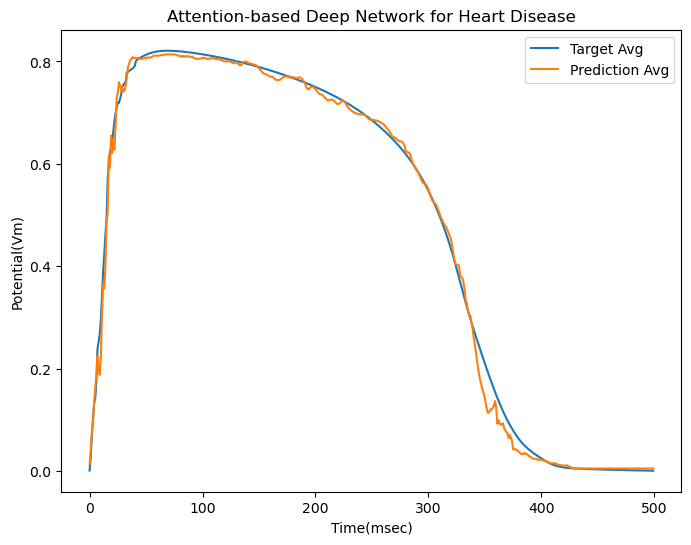

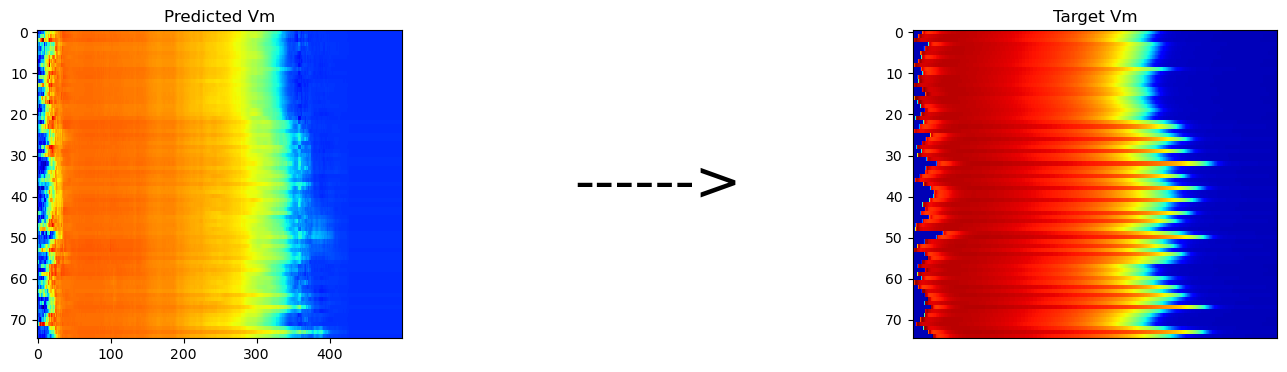


[+:] -- Metrics --
RSE:  0.2363519956502523
MAE:  0.03652589916900557
RMSE:  0.08164223411317503
MSE:  0.006665454390990482


In [ ]:
def predictOnce(mdl, X1= ecg_test, X2= volt_test):
    # [X1, X2] = [ecg_test, volt_test]
    ix = np.random.randint(0, len(X1), 1)
    src_ecg, tar_vm = X1[ix], X2[ix]
    gen_volt = mdl.predict(src_ecg)
    print('prediction: ', gen_volt.shape, 'truth: ', tar_vm.shape)
    # predAvg= np.load('vmTruth.npy')
    # print('vmTruth: ', pred.shape)
    return tar_vm, gen_volt, src_ecg

def compareVolt(tar, gen, src):
    print(src.shape,'--->', tar.shape,' []:==>  ', gen.shape)
    plt.figure(figsize = (8,6 ))
    plt.plot(range(500), np.mean(tar[0], axis=1), label= 'Target Avg')
    plt.plot(range(500), np.mean(gen[0], axis=1), label= 'Prediction Avg')
    plt.xlabel('Time(msec)')
    plt.ylabel('Potential(Vm)')
    plt.title(mdlLbl)
    plt.legend()
    plt.show()

def voltMap(tar, gen):
    row = 1
    column = 3
    plt.figure(figsize=(16,4))
    plt.subplot(row, column, 1)
    plt.imshow(gen.T, cmap='jet', interpolation='nearest', aspect='auto')
    plt.title('Predicted Vm')
    plt.subplot(row, column, 2)
    plt.text(0.5, 0.5, '------>', fontsize=40, horizontalalignment='center', verticalalignment='center')
    plt.axis('off')
    plt.subplot(row, column, 3)
    plt.imshow(tar.T, cmap='jet', interpolation='nearest', aspect='auto')
    plt.xticks([])
    plt.title('Target Vm')
    plt.show()
    plt.close()


def metrics(pred , true):
    def RSE(pred, true):
        return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))
    def CORR(pred, true):
        u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0)
        d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
        return (u/d).mean()
    def Corr(pred, true):
        sig_p = np.std(pred, axis=0)
        sig_g = np.std(true, axis=0)
        m_p = pred.mean(0)
        m_g = true.mean(0)
        ind = (sig_g != 0)
        corr = ((pred - m_p) * (true - m_g)).mean(0) / (sig_p * sig_g)
        corr = (corr[ind]).mean()
        return corr
    def MAE(pred, true):
        return np.mean(np.abs(pred-true))
    def MSE(pred, true):
        return np.mean((pred-true)**2)
    def RMSE(pred, true):
        return np.sqrt(MSE(pred, true))
    def MAPE(pred, true):
        return np.mean(np.abs((pred - true) / true))
    def MSPE(pred, true):
        return np.mean(np.square((pred - true) / true))
    def metric(pred, true):
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        #corr1 = CORR(pred, true)
        corr = Corr(pred, true)
        return mae,mse,rmse,mape,mspe,corr
    #need: rse, mse, rmse, mae
    print('\n[+:] -- Metrics --')
    print('RSE: ', RSE(pred, true))
    print('MAE: ',MAE(pred, true))
    print('RMSE: ',RMSE(pred, true))
    print('MSE: ', MSE(pred,true))

#---------------------------------------------------------------------------
'''
predictOnce(mdl, X1= ecg_test, X2= volt_test):
def compareVolt(tar, gen, src):
def voltMap(tar, gen):
def metrics(pred , true):
'''

if (predict):
    print('curentModel: ', currentModel)
    tar, gen, src= predictOnce(mdl= mdl)
    compareVolt(tar, gen, src)
    voltMap(tar, gen)
    metrics(pred= gen, true=tar)

